### variables to set

In [44]:
darkMode = True
PupBlackWhite = False

# Importing Modules 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [46]:
import pickle
import scipy.io as sio
from basicFunctions.filters import \
                        butter_bandpass_filter,butter_highpass_filter,butter_lowpass_filter
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from intanRead.IntanRaw_read_data import IntanRaw_read_data

from mainFunctions.loadDataFilePath import loadDataFilePath
from mainFunctions.readDigitalChannels import readDigitalChannels
from mainFunctions.readAnalogChannels import readAnalogChannels
from mainFunctions.stimOnsetExtraction import stimOnsetExtraction
from mainFunctions.loadSpikesFromPhy import loadSpikesFromPhy
from mainFunctions.neuronsInfoExtraction import neuronsInfoExtraction
from mainFunctions.pupilSizeReading import pupilSizeReading
from mainFunctions.spikeTriggeredAvgPupilSize import spikeTriggeredAvgPupilSize
from mainFunctions.neuronVisualResponse import neuronVisualResponse
from mainFunctions.tuningCurveAndOSI import tuningCurveAndOSI
from mainFunctions.extractLowAndHighArousalTrials import extractLowAndHighArousalTrials
from mainFunctions.allTrialsResponses import allTrialsResponses
from mainFunctions.responseChangeByAlertness import responseChangeByAlertness
from mainFunctions.bestOrienationResponseChangeByAlertness\
                    import bestOrienationResponseChangeByAlertness
from mainFunctions.noiseCorrBetweenAlertAndNonAlertTrials\
                    import noiseCorrBetweenAlertAndNonAlertTrials
from mainFunctions.powerSpectrumSingleChannel import powerSpectrumSingleChannel
from mainFunctions.estimatedL5chnnael import estimatedL5chnnael
from mainFunctions.exctractAlertAndNonAlertPeriods\
                    import exctractAlertAndNonAlertPeriods
from mainFunctions.spectrumCompareAlertNonAlert\
                    import spectrumCompareAlertNonAlert

darkMode = True

if darkMode:
        plt.style.use('dark_background')

## Getting the data file

In [49]:
dataFileAdd, dataFileBaseFolder, infoFileAdd = loadDataFilePath\
                            ("X:\Ehsan-temp\Claire-Ehsan_Share")

## Reading the info file

In [50]:
infoResult = IntanRaw_read_data(infoFileAdd)
channelsNo = len(infoResult['amplifier_channels'])
ADC_channelsNo = len(infoResult['board_adc_channels'])
fs = int(infoResult['frequency_parameters']['board_dig_in_sample_rate'])


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 64 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 6 board ADC channels.
Found 16 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.1 seconds


### Reading the digital data file

In [51]:
stimID, firstBeforeStimTagSampleNo, lastStimTagSampleNo, digitalTagStimOnsetEstimation\
                    = readDigitalChannels(dataFileBaseFolder)

if PupBlackWhite:
    stimID = np.ones(stimID.shape)

### Reading the analog data file to extract raw photoDiodeSignal and raw camerastrob

In [52]:
photoDiodeSignal, cameraStrobe = readAnalogChannels(dataFileBaseFolder,ADC_channelsNo)

### pupil size and camera strobe extraction

105024 :Number of strobe signals
105024 :Number of saved frames
these two numbers should be the same


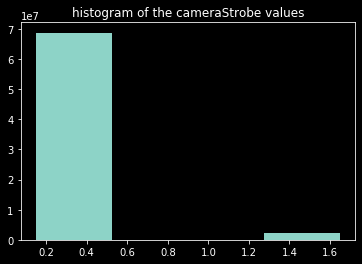

In [53]:
framesStartSample, pupilSmoothArea, pupilArea, firstCapturedFrame_Sample, lastCapturedFrame_Sample = \
                                    pupilSizeReading(cameraStrobe,dataFileBaseFolder,\
                                                     histBinNumber=4,darkMode = darkMode)

### if the pupil data isn't valid set the "pupilData" variable to "False"

In [54]:
pupilData = True

### stimOnset based on the photoDiode Signal or Digital Tags

600 : detected stim onsets from the photodiode sensor


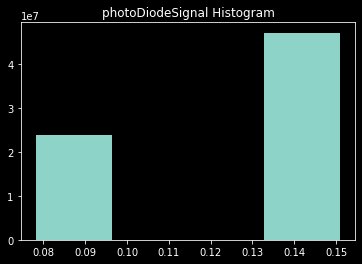

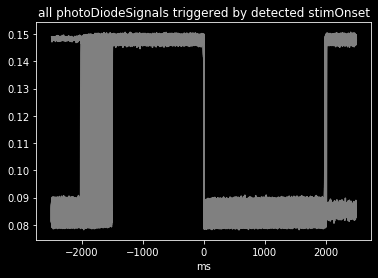

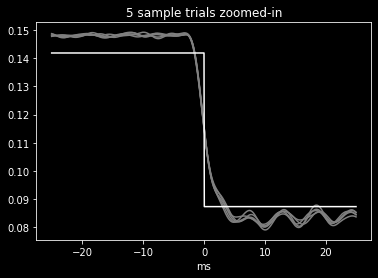

In [55]:
stimOnsetSample = stimOnsetExtraction(photoDiodeSignal,firstBeforeStimTagSampleNo,\
                                      lastStimTagSampleNo, digitalTagStimOnsetEstimation, fs\
                                      ,lowPassfilterBand = 300)

## loading the sorting results from KiloSort-Phy

#### Ctl+s in Phy first!

In [56]:
spikeTime, spikeClusters, SUA_clusters, MUA_clusters = loadSpikesFromPhy(dataFileBaseFolder)

[10 15 17 18 20 21 22 24 26 29 33 41 42 61 64 68] these clusters numbers should be the same as the ones that have been asigned as good units in Phy


## Extracting the spike wave-shapes, spont FRs and the channels

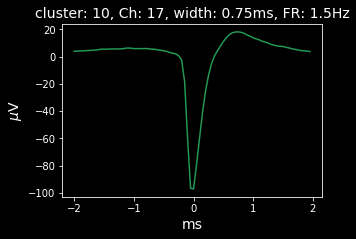

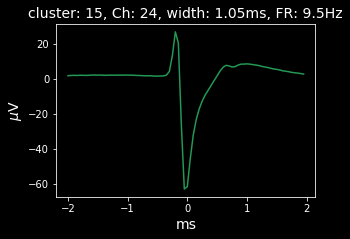

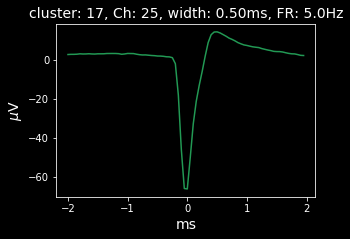

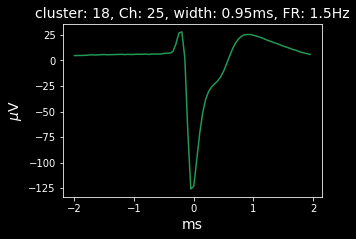

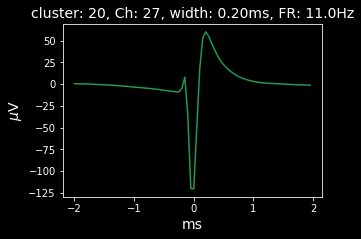

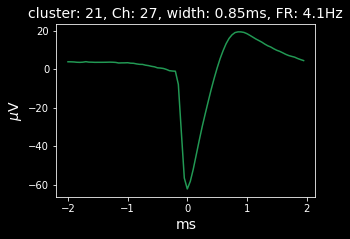

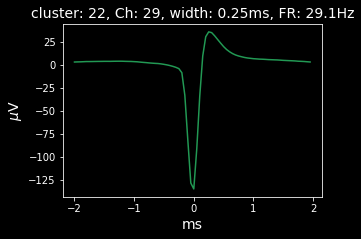

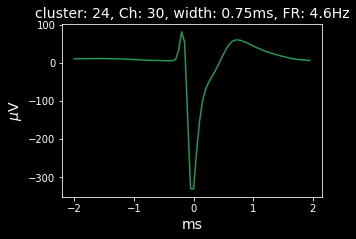

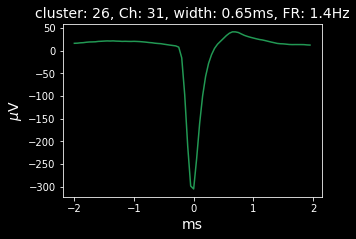

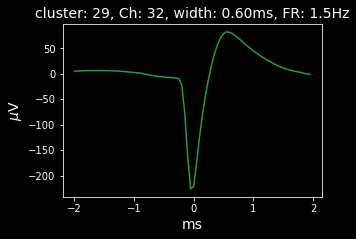

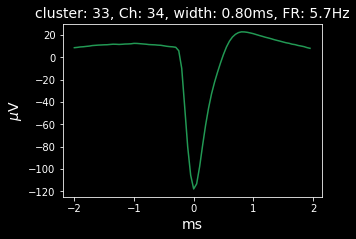

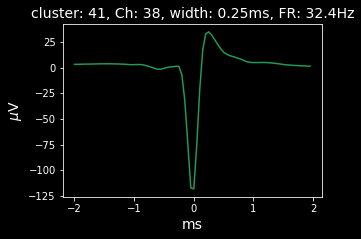

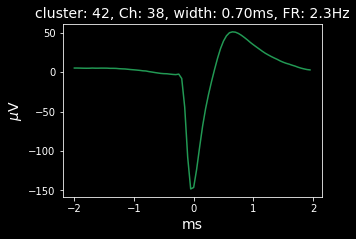

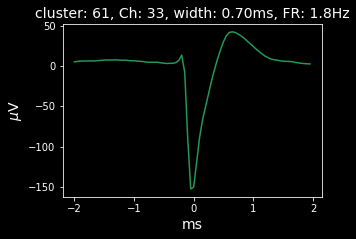

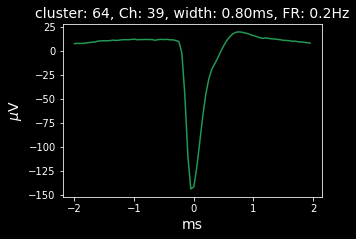

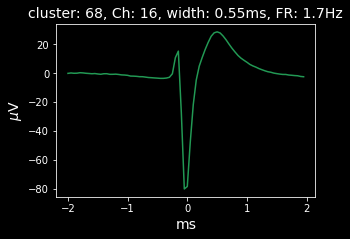

In [57]:
spontFRs, spikeWidthAll, clusterChannel, spikeShapesFiltered, spikeClustersToPlot, recordingDurInMS = \
    neuronsInfoExtraction(dataFileAdd, spikeTime, spikeClusters, SUA_clusters, MUA_clusters, firstBeforeStimTagSampleNo,\
                          fs, spikeTypes = 'SUA')

### spike-triggered Average of pupil size

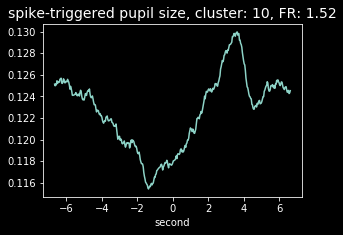

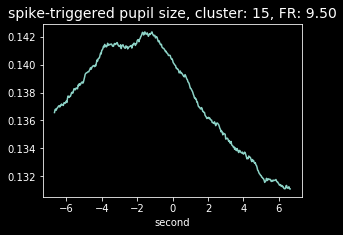

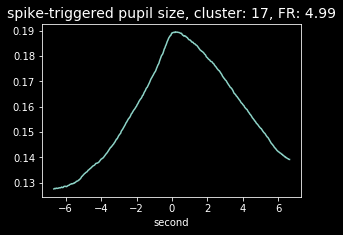

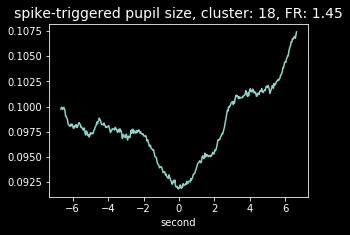

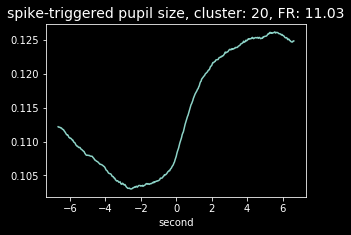

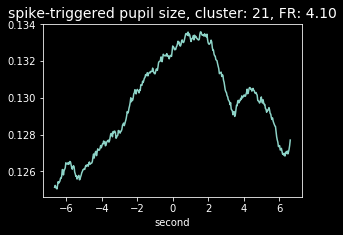

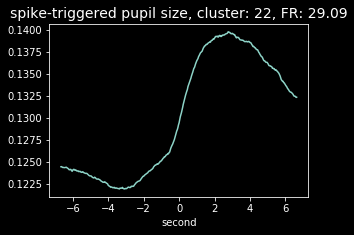

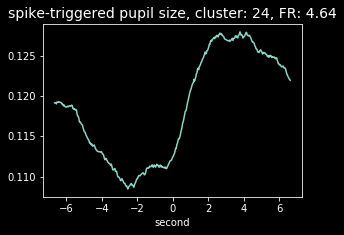

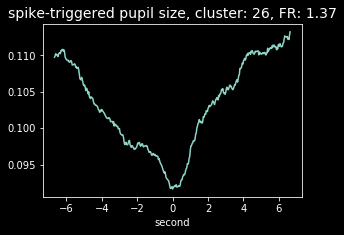

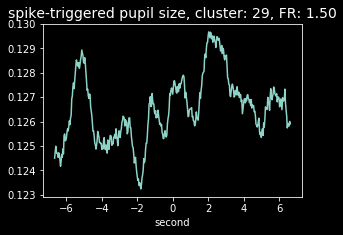

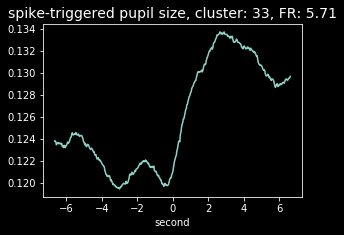

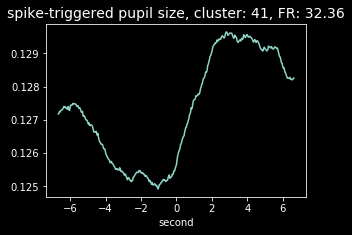

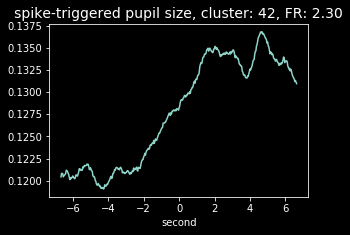

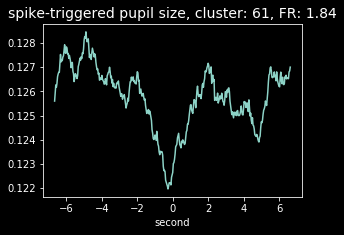

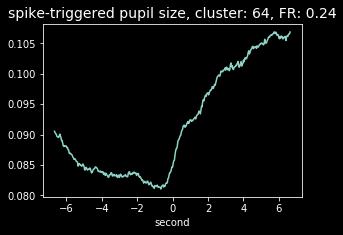

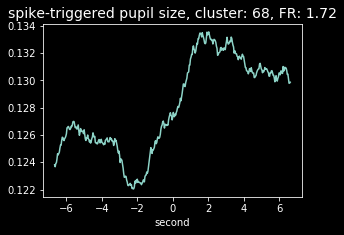

In [58]:
 if pupilData:
    allSpikeTriggeredPupil = spikeTriggeredAvgPupilSize(framesStartSample,\
                                     pupilSmoothArea, spikeClustersToPlot, spikeTime, spikeClusters,\
                                                       lastCapturedFrame_Sample, spontFRs)

### visual responsiveness of neurons

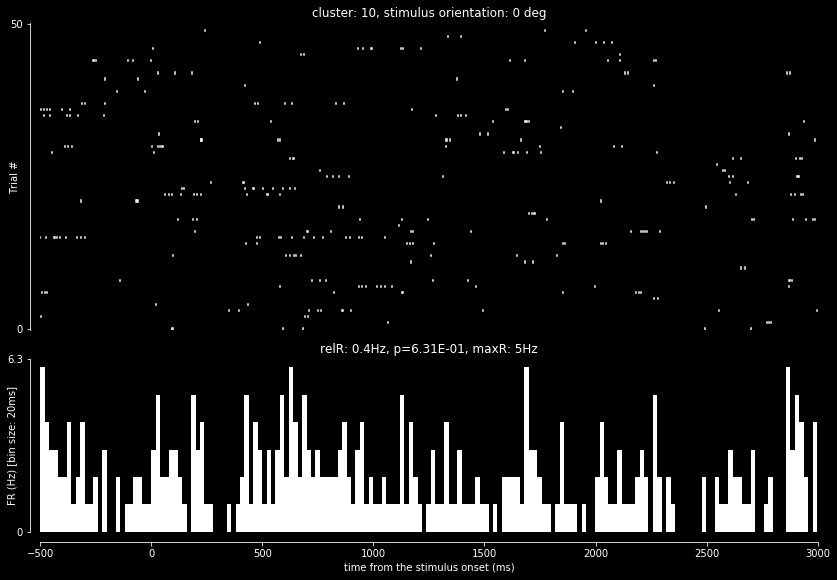

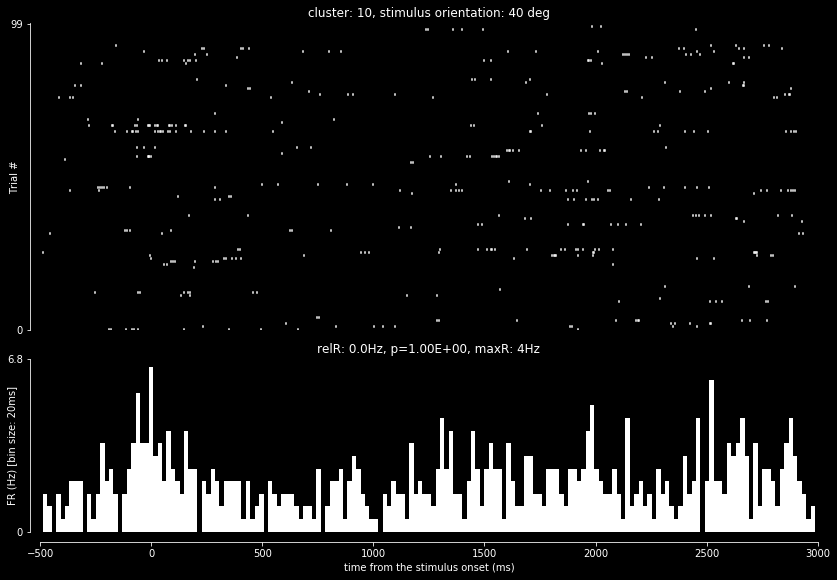

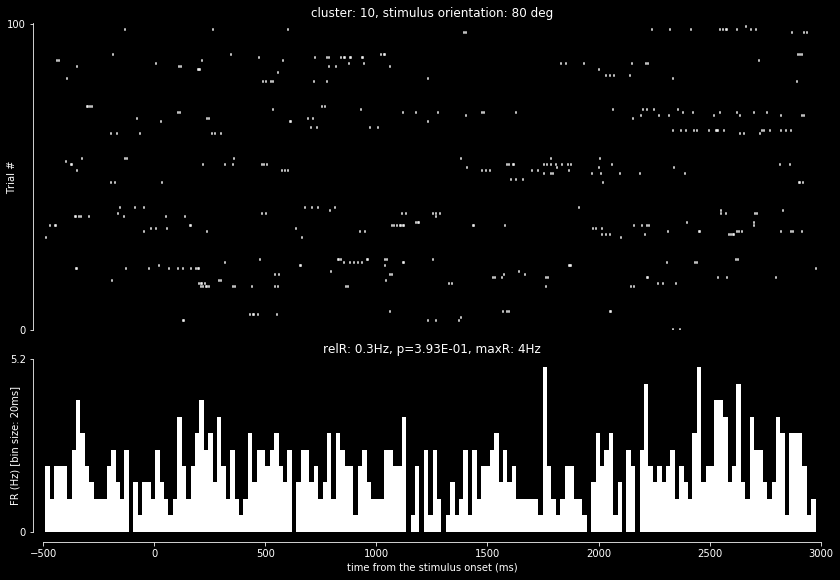

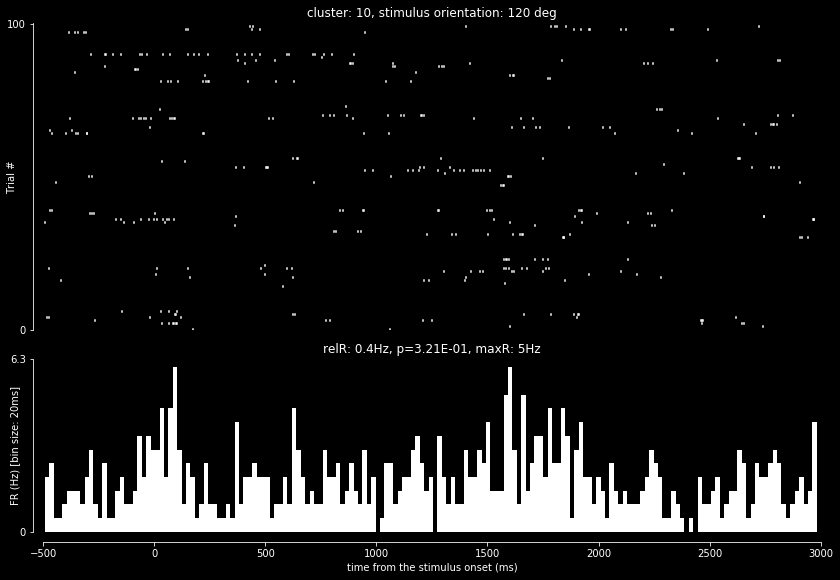

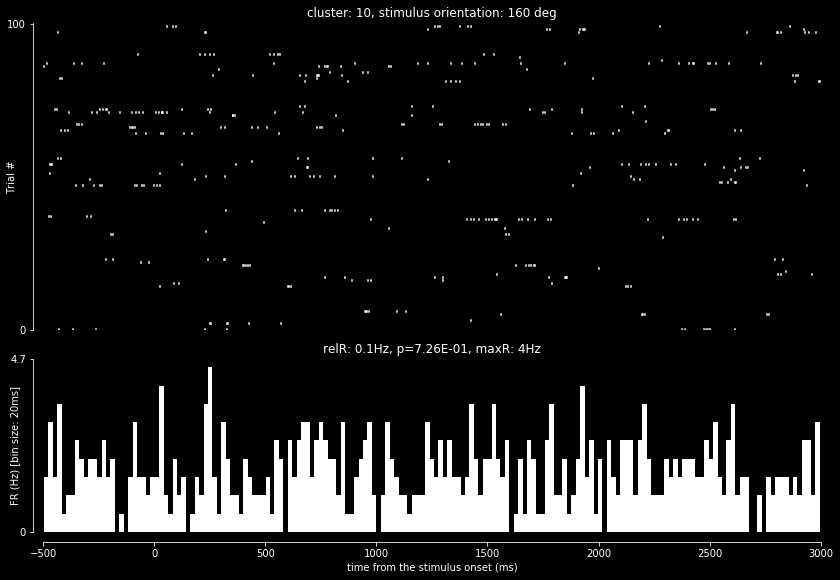

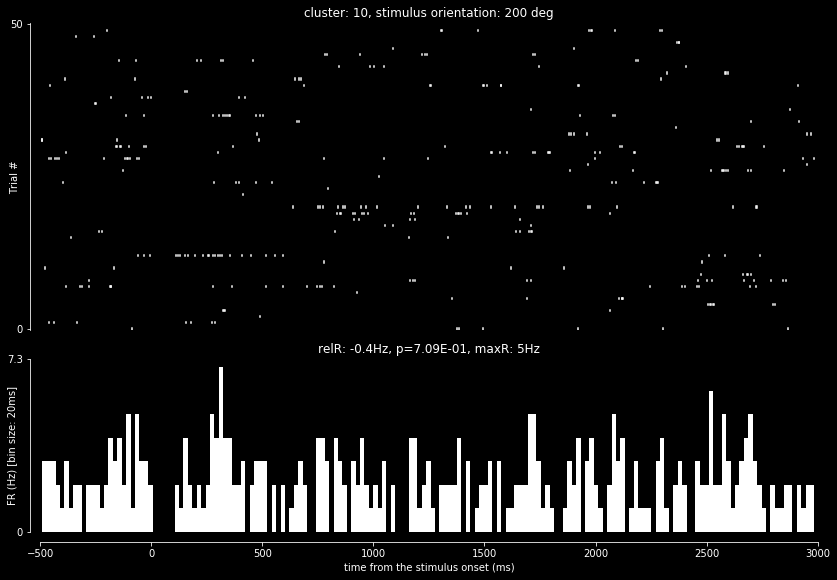

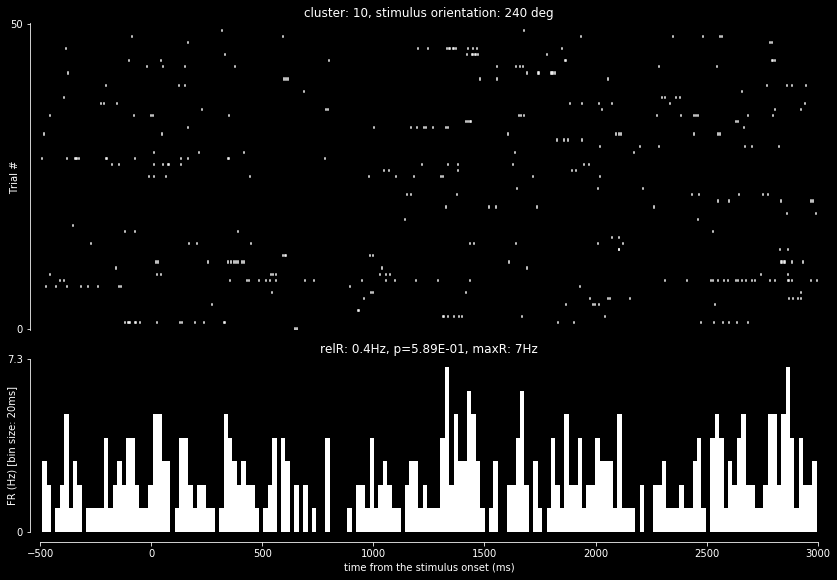

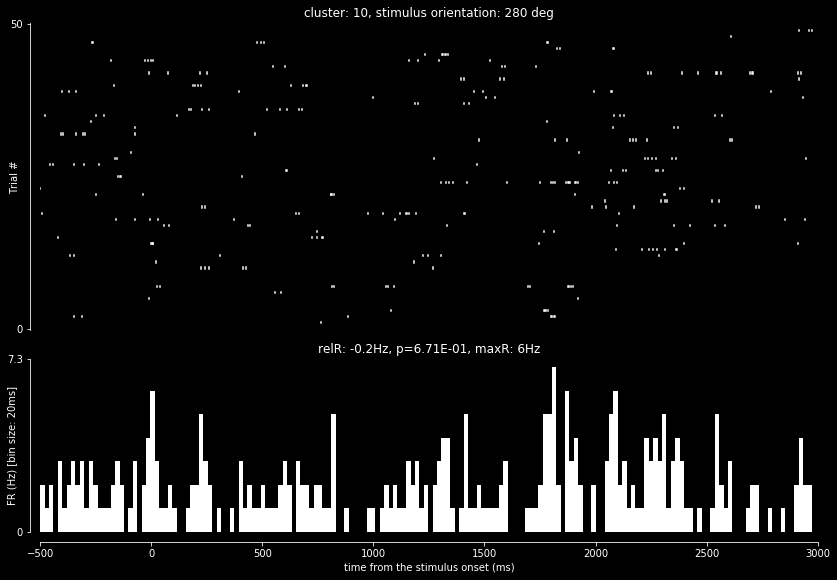

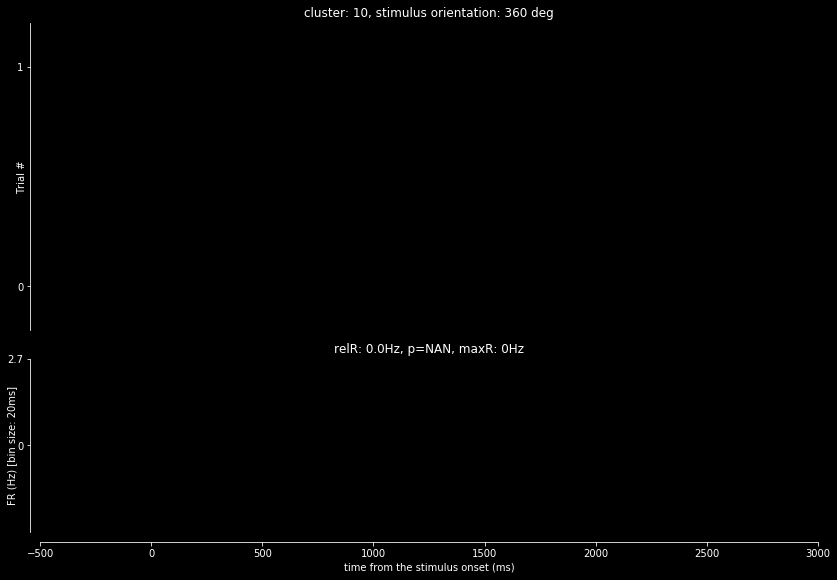

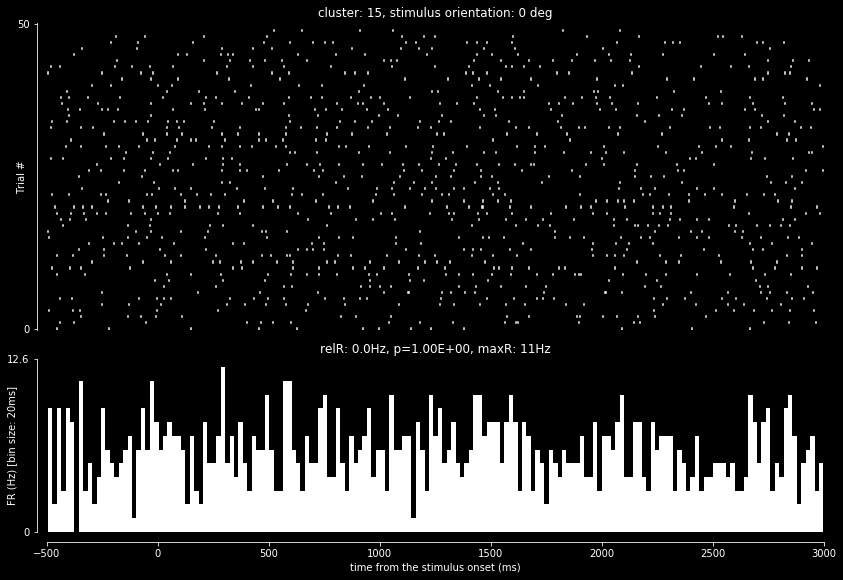

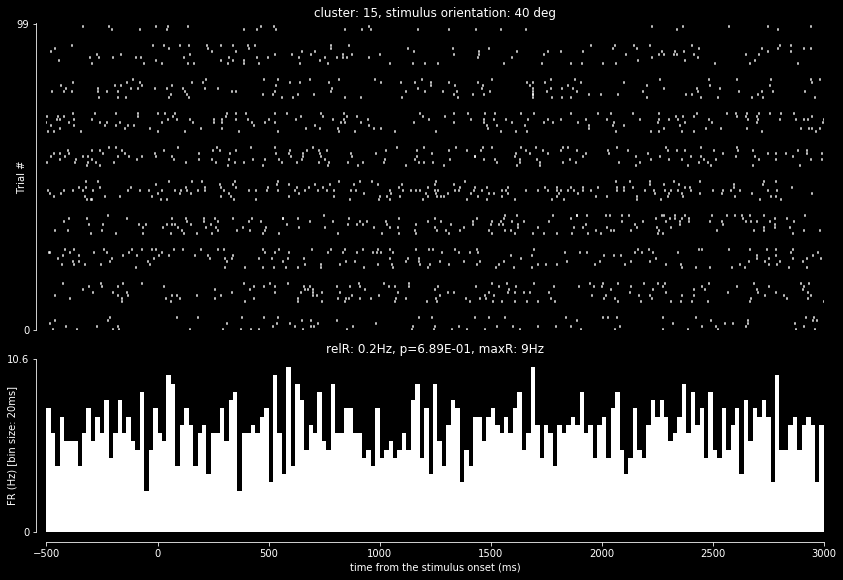

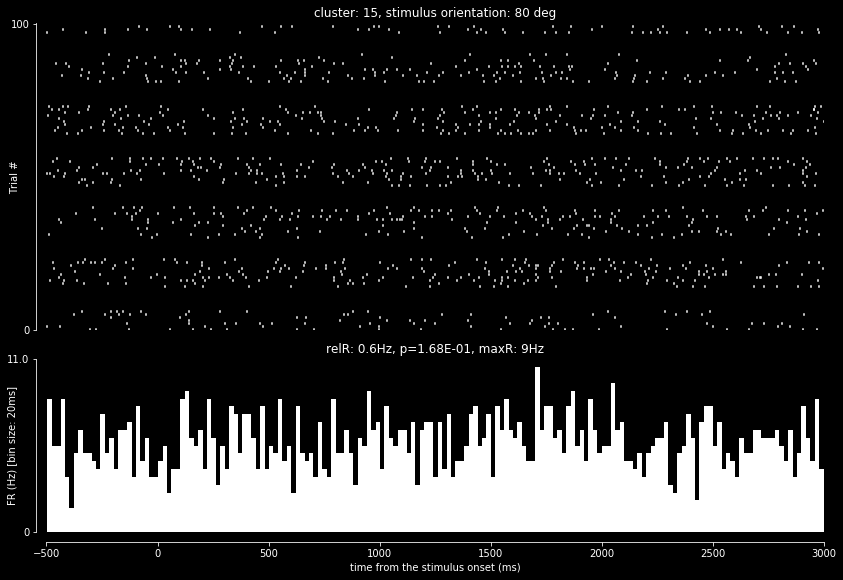

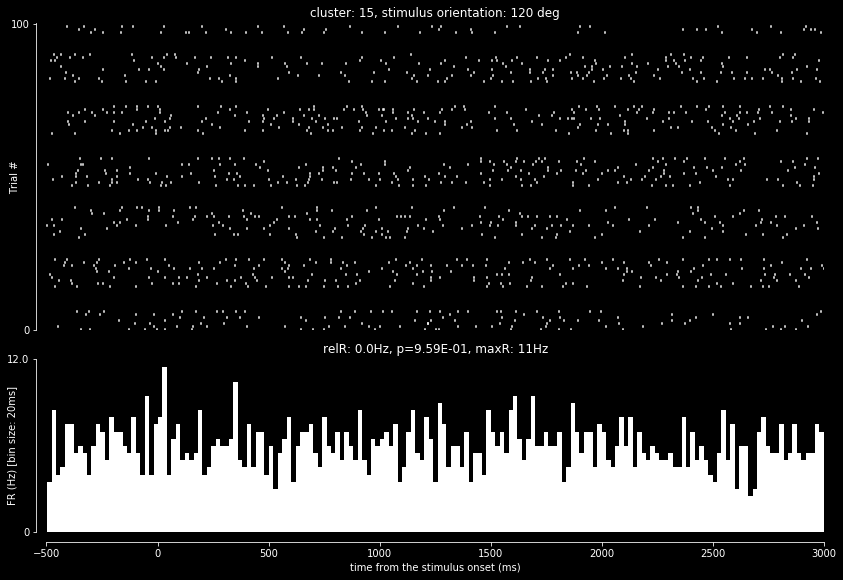

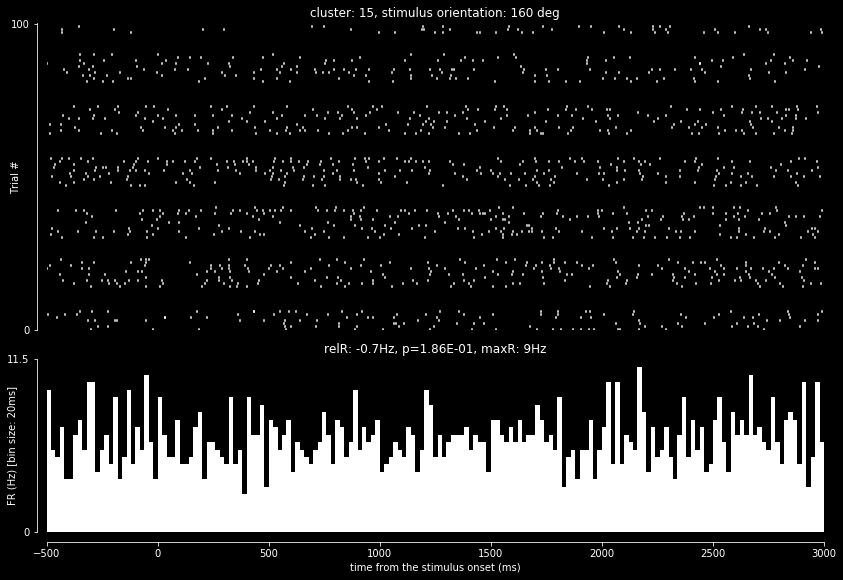

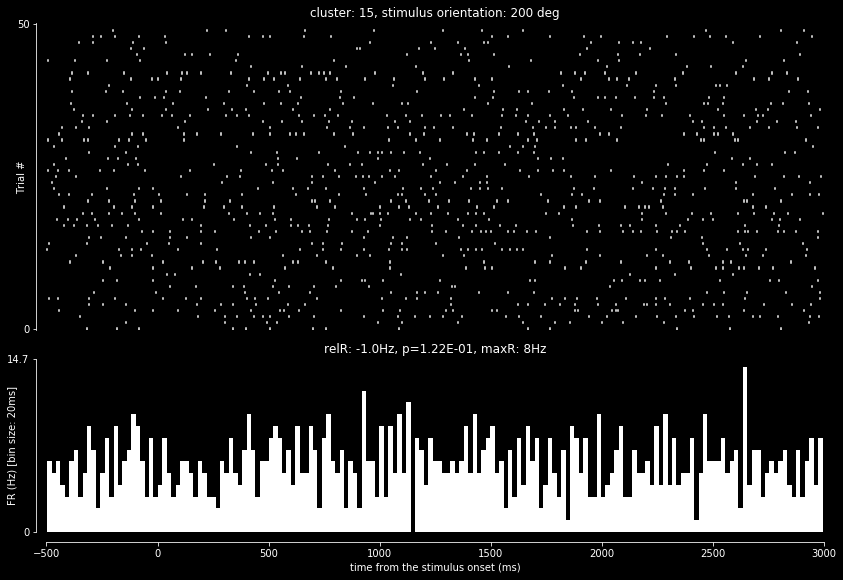

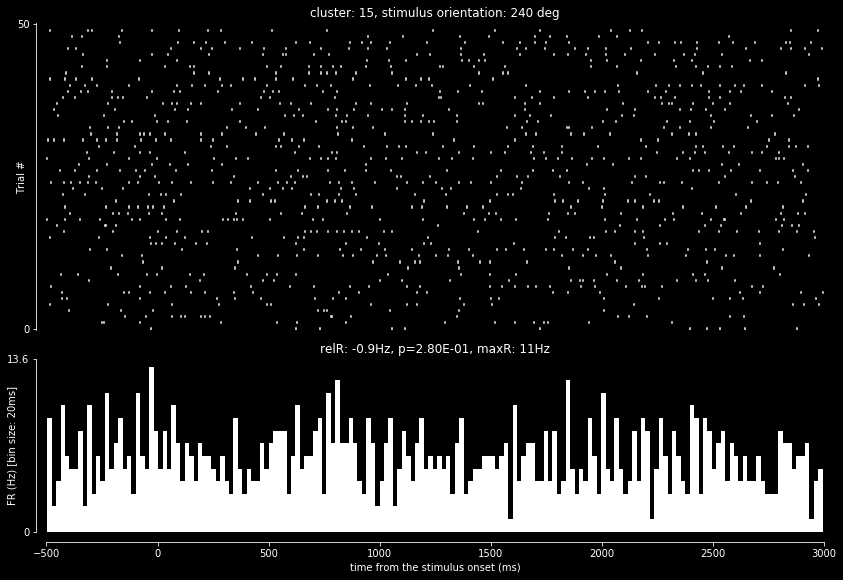

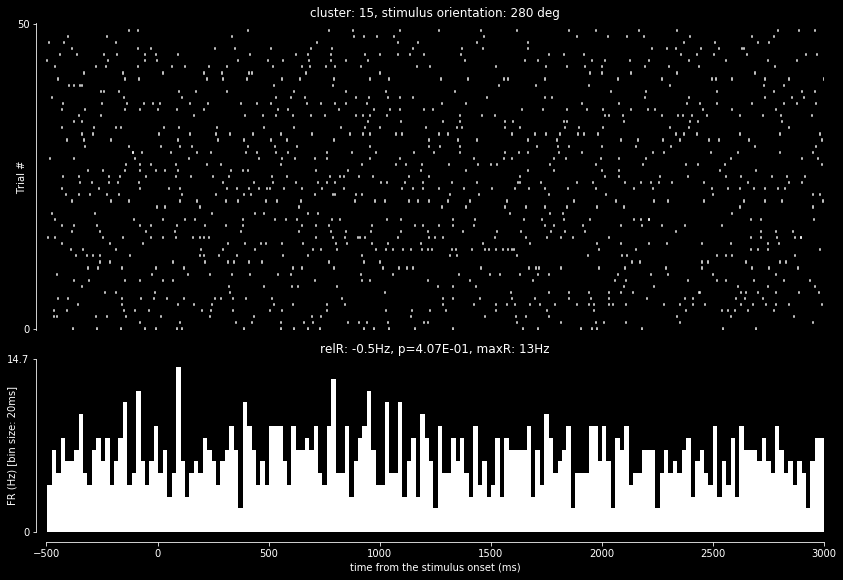

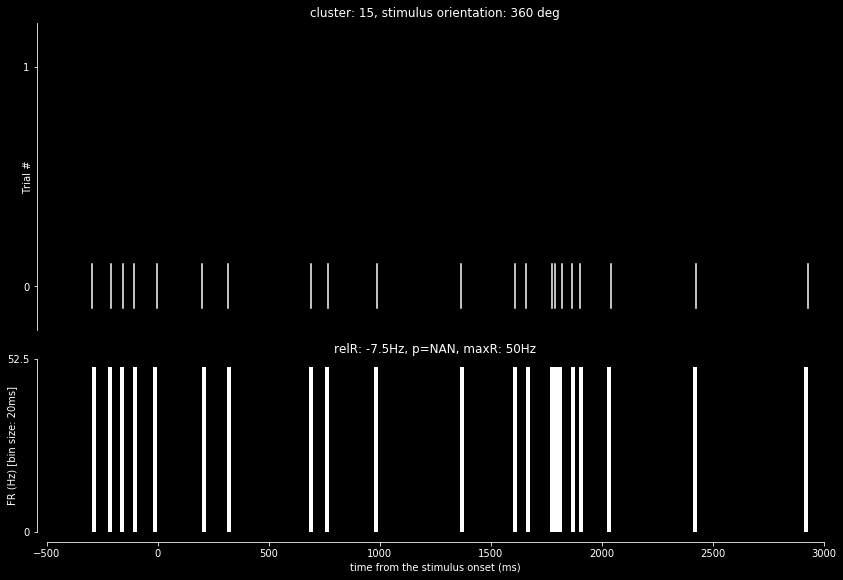

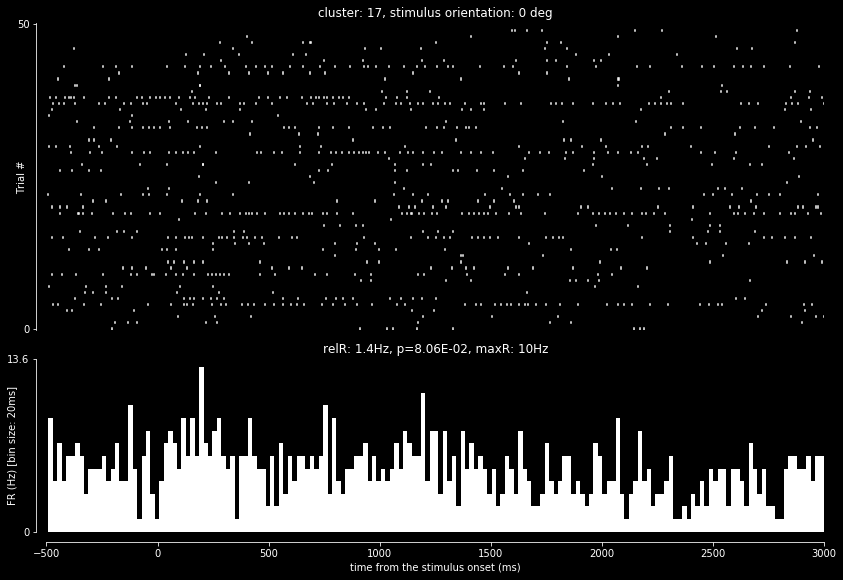

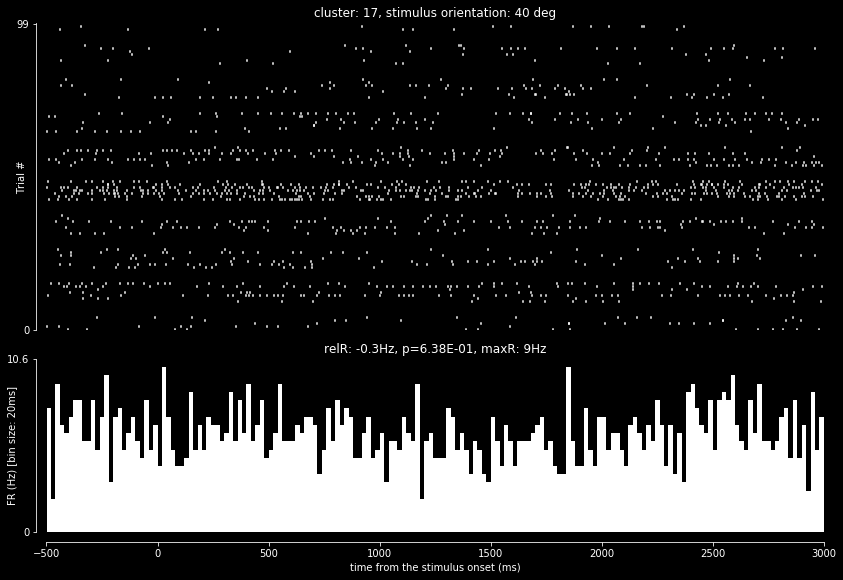

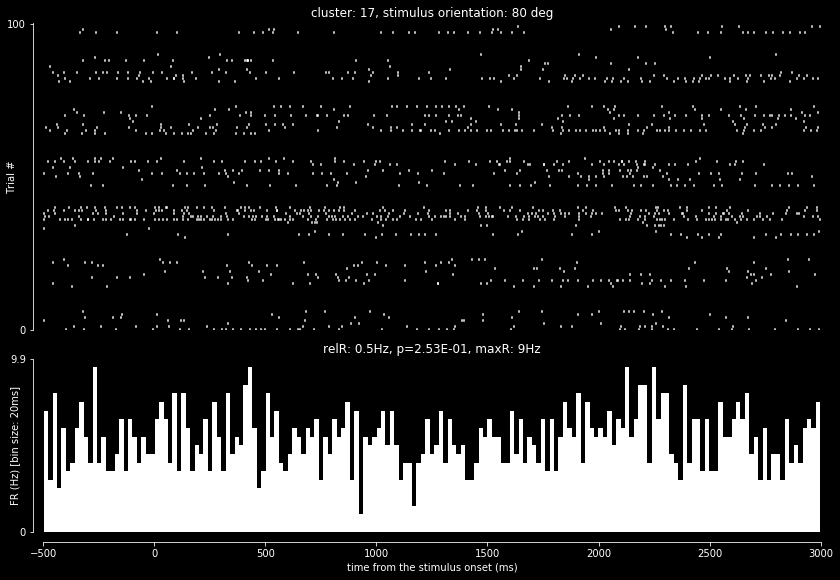

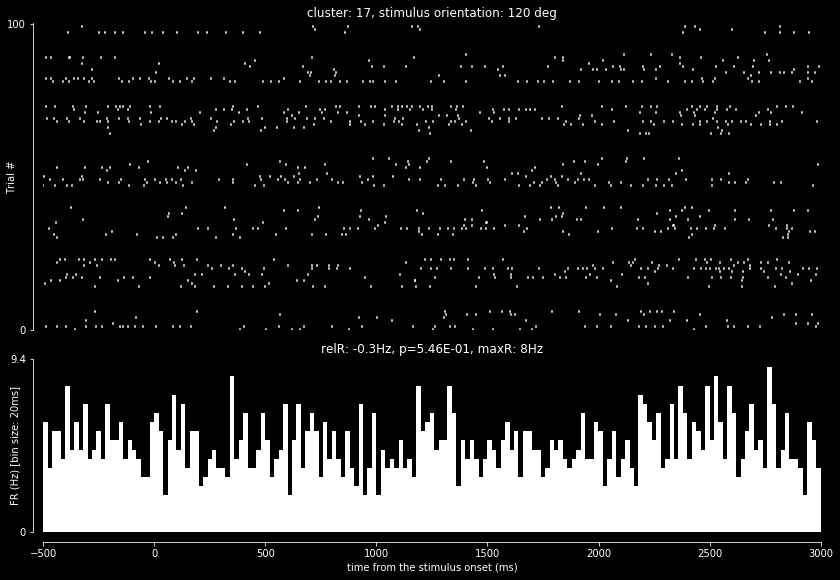

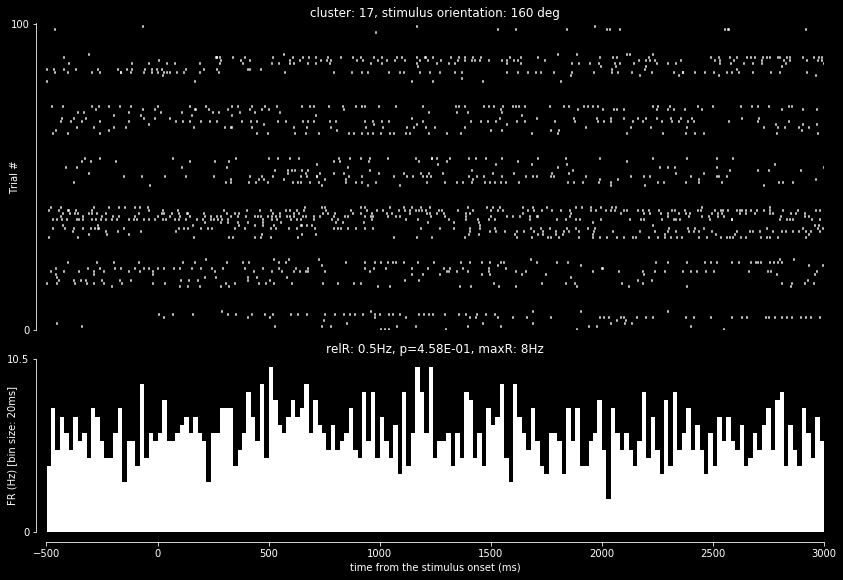

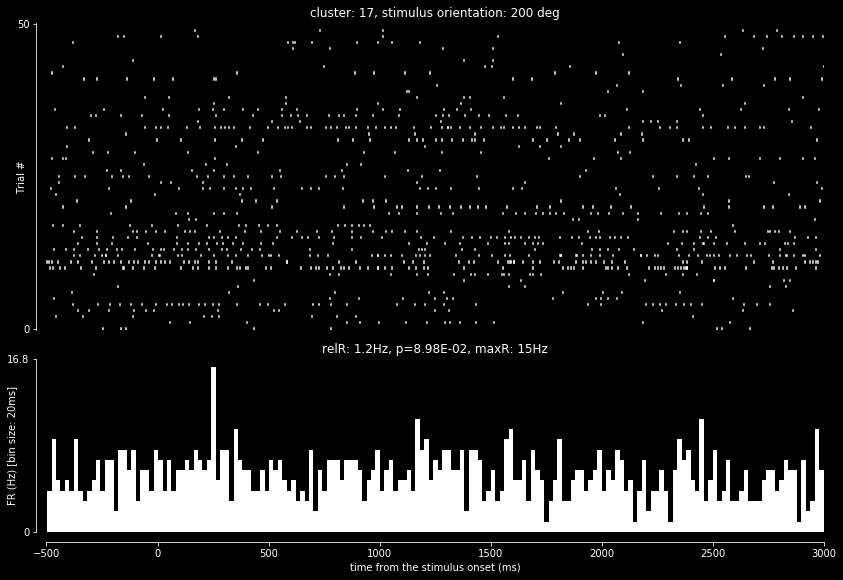

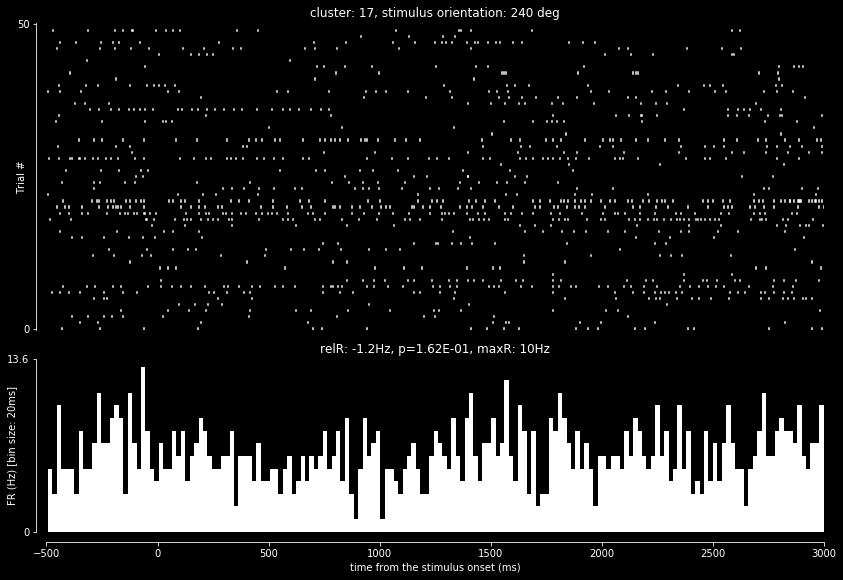

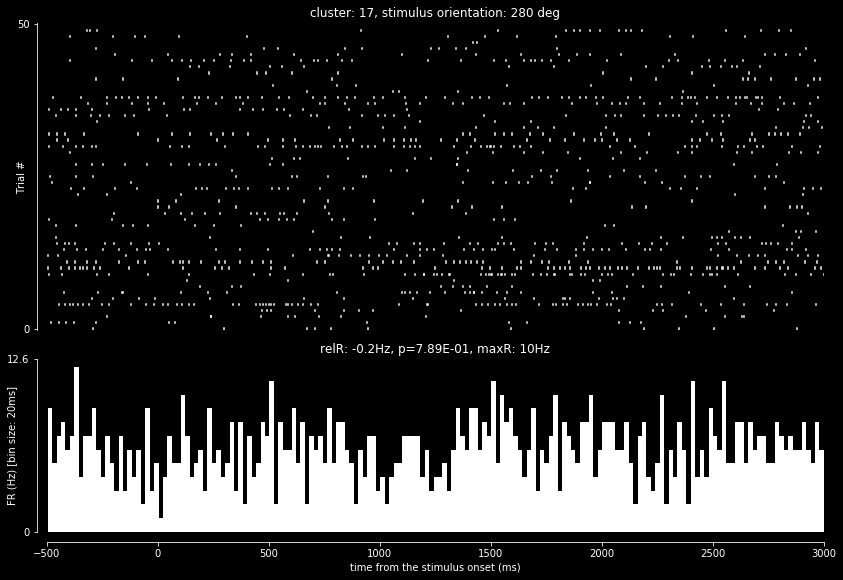

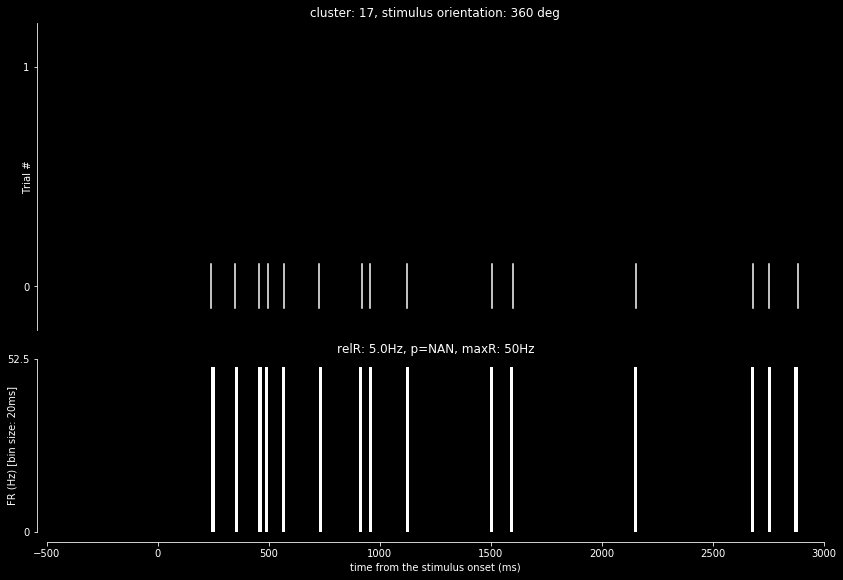

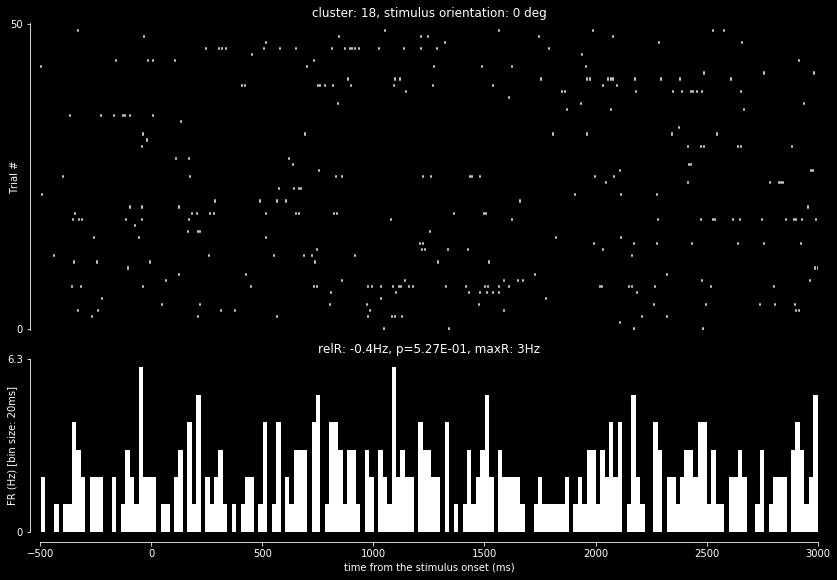

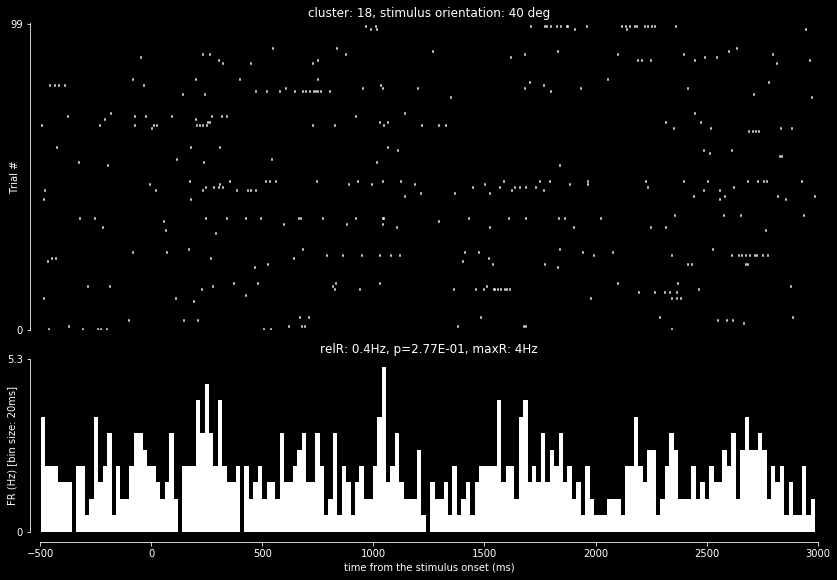

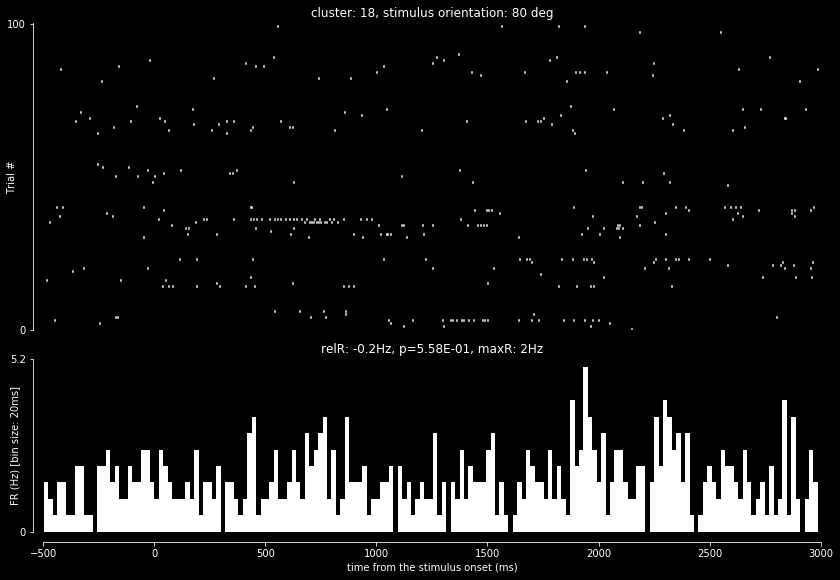

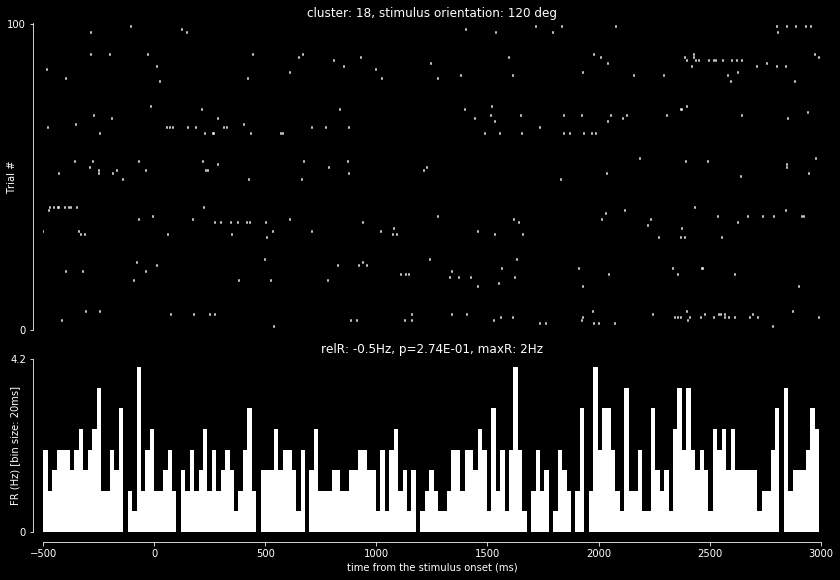

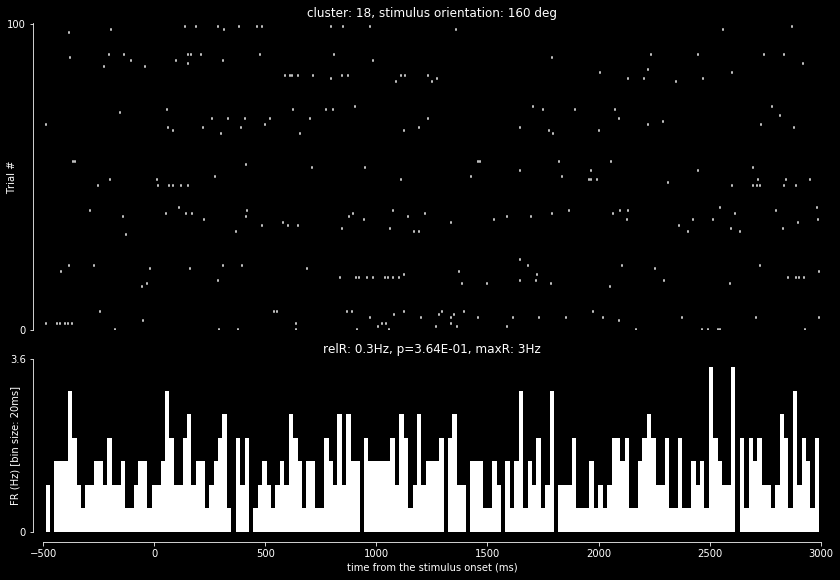

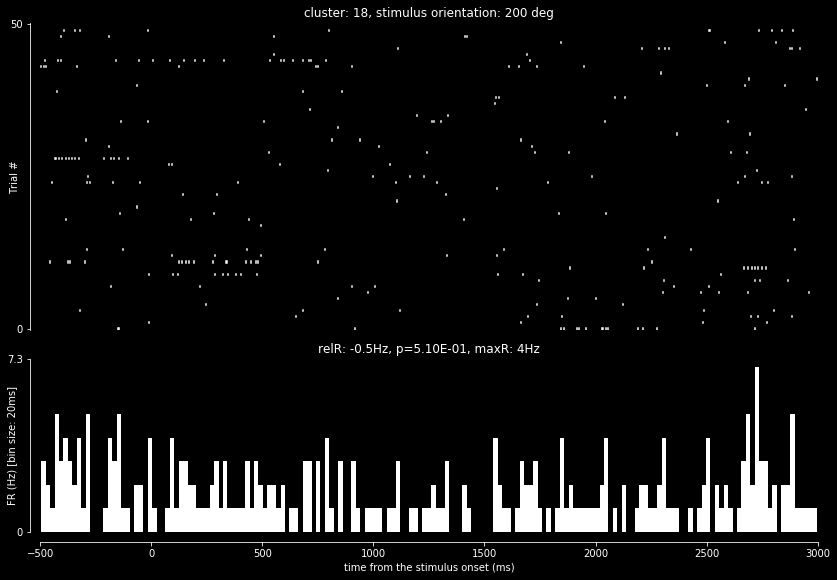

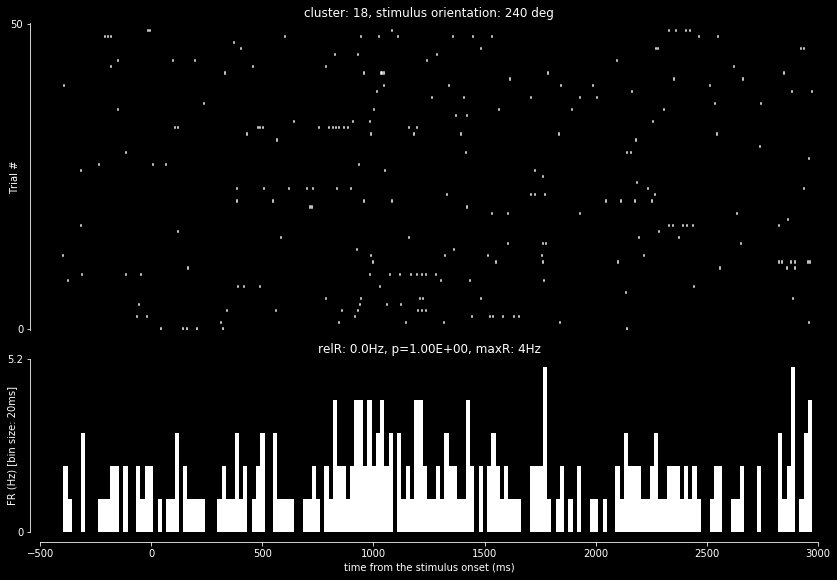

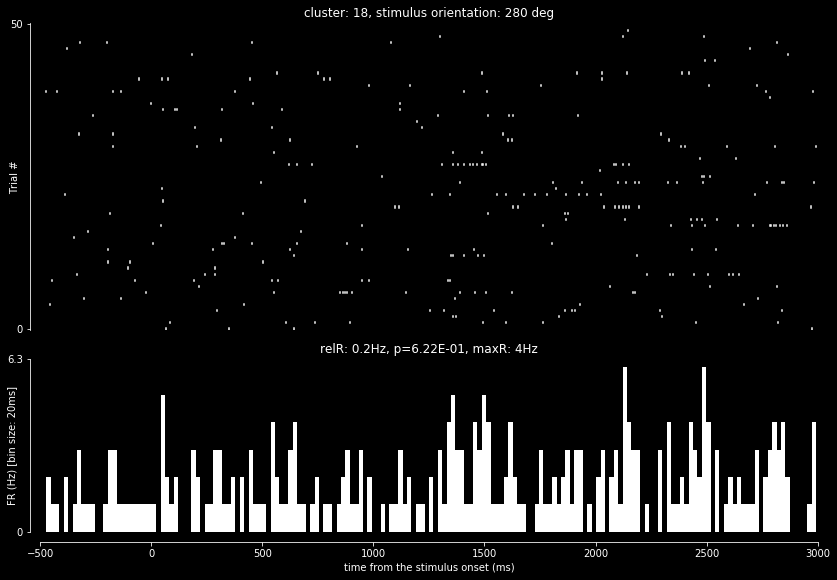

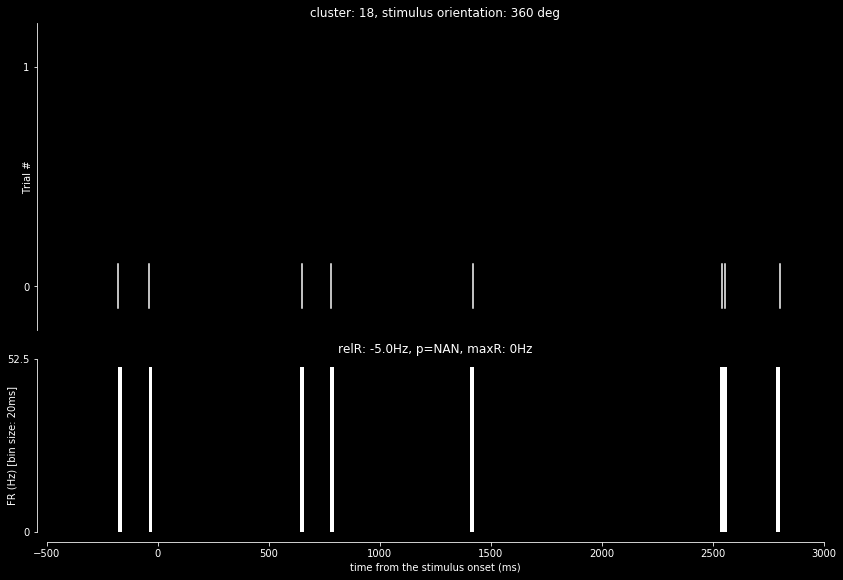

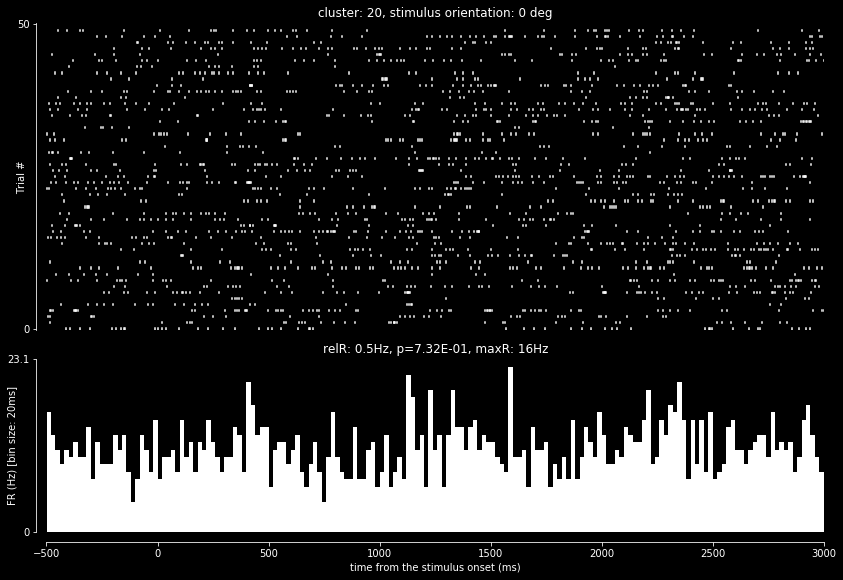

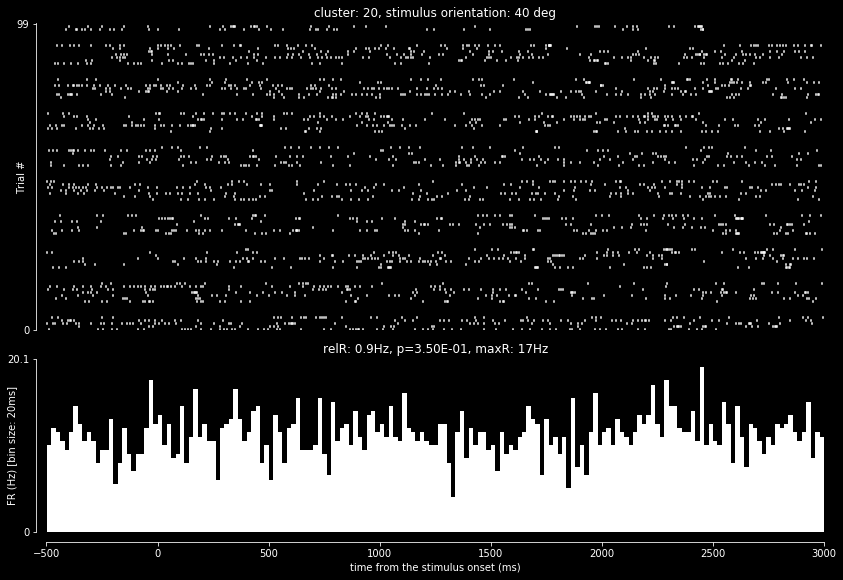

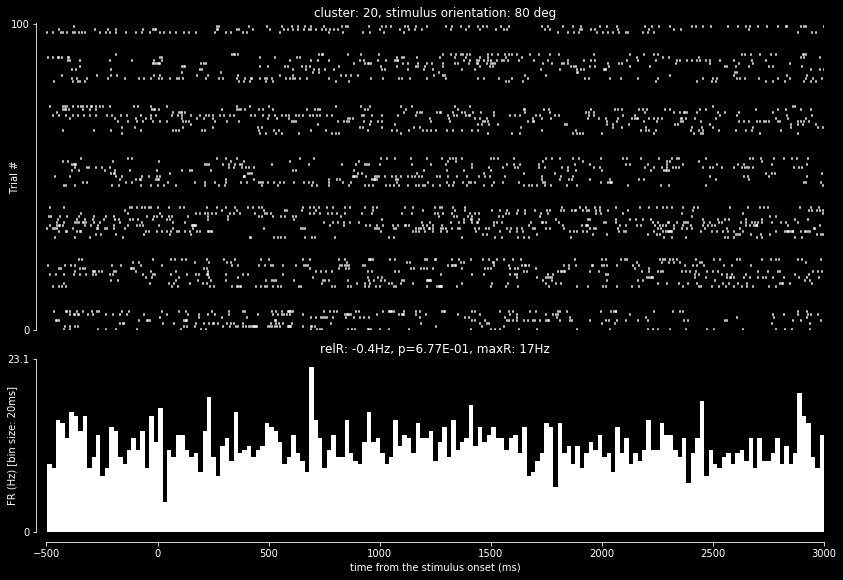

In [ ]:
allClustersResponsiveness = []
allClustersBaselineCorrectedResponse = []
allClustersMaxFR_response = []

for clusterNo in spikeClustersToPlot[:]:
    responsiveness, clusterBaselineCorrectedResponse, clusterMaxResponse, clusterResponsivenessPvals = \
        neuronVisualResponse(clusterNo,spikeTime,spikeClusters,stimID,stimOnsetSample, \
                             responseWindowEnd = 3000, darkMode = darkMode);
    
    allClustersResponsiveness.append(responsiveness)
    allClustersBaselineCorrectedResponse.append(clusterBaselineCorrectedResponse)
    allClustersMaxFR_response.append(clusterMaxResponse)

### Tuning curve and Orienation Selectivity Index

In [17]:
allOSI = []
# allOSI_max = []
for clusterCounter in range(len(spikeClustersToPlot)):
    if allClustersResponsiveness[clusterCounter]:
        allOSI.append(tuningCurveAndOSI(allClustersBaselineCorrectedResponse[clusterCounter],\
                                       spikeClustersToPlot[clusterCounter]));
#     allOSI_max.append(tuningCurveAndOSI(allClustersMaxFR_response[clusterNo]))

### Individual Trials Responses

### Baseline and Evoked comparison between alert and non alert trials

In [18]:
numberOfResponsiveClusters = np.where(allClustersResponsiveness)[0].shape[0]
if numberOfResponsiveClusters: #if we have any responsive channel
    
    allTrialsRelResponse, allTrialsBaseline, allTrialsEvokedResponse\
                        = allTrialsResponses(spikeClusters, spikeTime, stimOnsetSample,\
                            spikeClustersToPlot[np.where(allClustersResponsiveness)])
    # Extracting the high and low-arousal level trials
    if pupilData:
        lowArousalStimTrials, highArousalStimTrials = \
                    extractLowAndHighArousalTrials(framesStartSample, pupilSmoothArea, stimOnsetSample,\
                        timeWindowBeforeStimStart = 500,\
                        timeWindowAfterStimStart = 0)

    
        # response change by alertness

        allClustersNormalizedArousalResponseChange, allPvalArousalResponseDiff = responseChangeByAlertness(\
                    spikeClustersToPlot[np.where(allClustersResponsiveness)],\
                    allTrialsRelResponse,highArousalStimTrials,lowArousalStimTrials)

        # Basline change by alertness
        allClustersNormalizedArousalBaselineChange, allPvalaselineChange = responseChangeByAlertness(\
                    spikeClustersToPlot[np.where(allClustersResponsiveness)],\
                    allTrialsBaseline,highArousalStimTrials,lowArousalStimTrials,\
                    figTitle = 'Baseline Change By Alertness')

        # Evoked response change in the preferred stim by alertness
        evokedResponseChangeByArousa, pvalEvokedResponseChange = \
        bestOrienationResponseChangeByAlertness(spikeClustersToPlot,allTrialsEvokedResponse,\
            highArousalStimTrials,lowArousalStimTrials,allClustersBaselineCorrectedResponse,\
            allClustersResponsiveness,stimID,figTitle = 'Evoked Response Change By Alertness in Preferred Direction ');

        # relative response change in the preferred stim by alertness
        bestDirectionRelResponseChangeByArousal, pvalBestDirectionResponseChange = \
        bestOrienationResponseChangeByAlertness(spikeClustersToPlot,allTrialsRelResponse,\
            highArousalStimTrials,lowArousalStimTrials,allClustersBaselineCorrectedResponse,\
            allClustersResponsiveness,stimID,figTitle = 'Relative Response Change By Alertness in Preferred Direction ');
    
else:
    allClustersNormalizedArousalResponseChange = []
    allClustersNormalizedArousalBaselineChange = []
    evokedResponseChangeByArousa = []
    bestDirectionRelResponseChangeByArousal = []
    lowArousalStimTrials = []
    highArousalStimTrials = []
    allTrialsRelResponse = []
    allTrialsBaseline = []
    allTrialsEvokedResponse = []

### Tuning Curve and OSI between Alert and non Alert

In [19]:
allClustersAlertMeanOrientationResponse = []
allClustersNonAlertMeanOrientationResponse = []
OSI_Alert = []
OSI_nonAlert = []

if numberOfResponsiveClusters & pupilData:
    for clusterCounter in range(len(np.where(allClustersResponsiveness)[0])):

        alertMeanOrientationResponse = []
        nonAlertMeanOrientationResponse = []
        for orientationCounter in np.unique(stimID):

            alertResponseCluster = allTrialsRelResponse[clusterCounter]\
                                [np.intersect1d(np.where(stimID==orientationCounter)[0], highArousalStimTrials)]

            nonAlertResponseCluster = allTrialsRelResponse[clusterCounter]\
                                [np.intersect1d(np.where(stimID==orientationCounter)[0], lowArousalStimTrials)]

            alertMeanOrientationResponse.append(np.mean(alertResponseCluster))
            nonAlertMeanOrientationResponse.append(np.mean(nonAlertResponseCluster))

        allClustersAlertMeanOrientationResponse.append(alertMeanOrientationResponse)
        allClustersNonAlertMeanOrientationResponse.append(nonAlertMeanOrientationResponse)
    #         print(stats.ttest_ind(alertResponseCluster,nonAlertResponseCluster)[1],\
    #              np.mean(alertResponseCluster),np.mean(nonAlertResponseCluster))

        OSI_Alert.append(tuningCurveAndOSI(alertMeanOrientationResponse,\
                                           spikeClustersToPlot[clusterCounter]))
        OSI_nonAlert.append(tuningCurveAndOSI(nonAlertMeanOrientationResponse,\
                                              spikeClustersToPlot[clusterCounter]))

    plt.figure()
    plt.plot([1,2],np.array([OSI_Alert,OSI_nonAlert]),'o-')
    plt.xticks([1,2],(['Alert','nonAlert']),fontsize=12)
    plt.title('OSI change with alertness')

### noise correlation between alert and non-alert trials

In [20]:
if numberOfResponsiveClusters and pupilData:
    noiseCorrAlert, noiseCorrNonAlert, pval = noiseCorrBetweenAlertAndNonAlertTrials\
        (allTrialsRelResponse,highArousalStimTrials,lowArousalStimTrials)
else:
    noiseCorrAlert = []
    noiseCorrNonAlert = []

    # print(stats.ttest_ind(noiseCorrAlert,noiseCorrNonAlert)[1],np.mean(noiseCorrAlert)\
    #               ,np.mean(noiseCorrNonAlert))

### power Spectrum in L5

#### estimated L5 channel

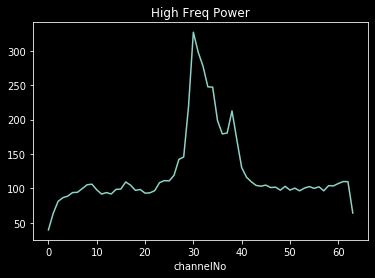

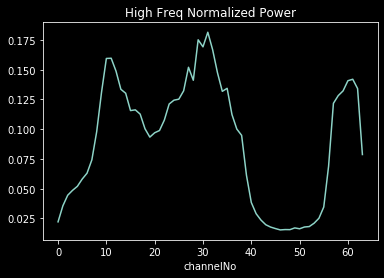

In [24]:
dataFileAddReorderRereferenced = dataFileBaseFolder + '/' + 'amplifierReorderRereferencedMedian.dat'
L5channelNo, allChannelsNormHighFreqPower,\
        allChannelsHighFreqPower = estimatedL5chnnael(dataFileAddReorderRereferenced,\
                                                      firstBeforeStimTagSampleNo)
L4channelNo = L5channelNo - 8
L23channelNo = L5channelNo - 15

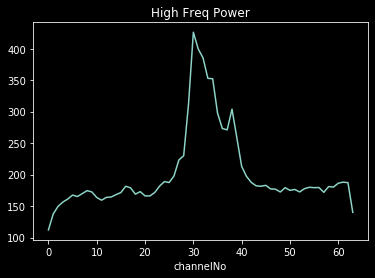

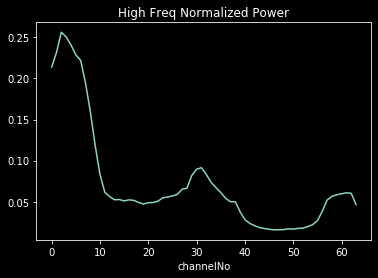

In [22]:
dataFileAddReorderRereferenced = dataFileBaseFolder + '/' + 'amplifierReorder.dat'
L5channelNo, allChannelsNormHighFreqPower,\
        allChannelsHighFreqPower = estimatedL5chnnael(dataFileAddReorderRereferenced,\
                                                      firstBeforeStimTagSampleNo)
if L5channelNo > 8:
    L4channelNo = L5channelNo - 8
else: # No valid L4
    L4channelNo = 0 
    
if L5channelNo > 15:
    L23channelNo = L5channelNo - 15
else: # No valid L3/2
    L23channelNo = 0

#### check L5 and if non valid change the L5channelValid to "False"

In [25]:
L5channelValid = True

if not(L5channelValid):
    L5channelNo = 0
    L4channelNo = 0
    L23channelNo = 0

#### reading low pass filtered data file

In [26]:
dataFile = open(dataFileBaseFolder + '/' + 'amplifierReorderRereferencedLowPass.dat' , 'rb')
dataArray = np.fromfile(dataFile,dtype='int16')
dataFile.close()

del dataFile

dataMatrixReorderLowPassFiltered = np.reshape(dataArray, (int(dataArray.shape[0]/channelsNo), channelsNo)).T

del dataArray

#### power spectrum on the channel estimated to be in L5 during spontaneous activity

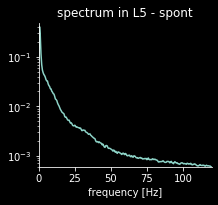

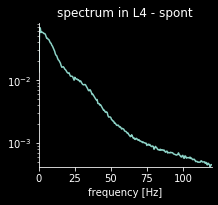

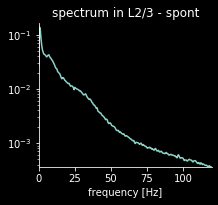

In [27]:
spontEndTime = firstBeforeStimTagSampleNo/fs # in seconds
reducedSamplingRate = 2e3
df = 0.5

if L5channelNo: #if valid L5 channel
    inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]\
                                     [:int(spontEndTime*reducedSamplingRate)]*0.195

    f_powerSpectrum, powerSpectrumL5, estimatedTotalPower = \
                powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                              ,figToShow = True,\
    maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L5 - spont' )
else:
    powerSpectrumL5 = []
    f_powerSpectrum = []

if L4channelNo: #if valid L4 channel
    inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]\
                                     [:int(spontEndTime*reducedSamplingRate)]*0.195

    f, powerSpectrumL4, estimatedTotalPower = \
                powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                              ,figToShow = True,\
    maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L4 - spont' )
else:
    powerSpectrumL4 = []
    
if L23channelNo: #if valid L23 channel
    inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]\
                                     [:int(spontEndTime*reducedSamplingRate)]*0.195

    f, powerSpectrumL23, estimatedTotalPower = \
                powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                              ,figToShow = True,\
    maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L2/3 - spont' )
else:
    powerSpectrumL23 = []

### power spectrum between alert and non alert periods

#### detecting the consecutive periods of alert and non alert

In [28]:
 if pupilData:
    alertChoosedEpochsStarts, alertChoosedEpochsEnds, nonAlertChoosedEpochsStarts, \
        nonAlertChoosedEpochsEnds = exctractAlertAndNonAlertPeriods(pupilSmoothArea,framesStartSample,\
                    0,spontEndTime,minimumConsistentStateDur = 10)

In [29]:
 if pupilData:
        
    if L5channelNo: #if valid L5 channel
        inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]
        f, alertSpectrumL5, nonAlertSpectrumL5 = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
                alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
             nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
             timeToExclude = 2, df = 2, figTitle = 'Spectrum L5')
    else:
        alertSpectrumL5 = []
        nonAlertSpectrumL5 = []

    if L4channelNo: #if valid L4 channel
        inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]
        f, alertSpectrumL4, nonAlertSpectrumL4 = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
                alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
             nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
             timeToExclude = 2, df = 2, figTitle = 'Spectrum L4')
    else:
        alertSpectrumL4 = []
        nonAlertSpectrumL4 = []

    if L23channelNo: #if valid L23 channel
        inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]
        f, alertSpectrumL23, nonAlertSpectrumL23 = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
                alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
             nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
             timeToExclude = 2, df = 2, figTitle = 'Spectrum L2/3')
    else:
        alertSpectrumL23 = []
        nonAlertSpectrumL23 = []



### variables to save

In [31]:
# 0 waveshapes
# 1 spikeWidth
# 2 spont FRs
# 3 clusterChannel
# 4 spike-triggered pupil area
# 5 responsiveness 
# 6 baselineCorrectedResponse
# 7 OSI
# 8 Alert OSI
# 9 nonAlert OSI
# 10 relative response Change By Arousal
# 11 basline change by arousal
# 12 evoked-response change by arousal
# 13 best direction response change by arousal
# 14 noise correlation alert
# 15 noise correlation non-alert
# 16 normalized high freq power on all channels
# 17 high freq power on all channels
# 18 power sepctrum L5
# 19 power spectrum L4
# 20 power spectrum L23
# 21 frequency vector
# 22 power spectrum alert L5
# 23 power spectrum non alert L5
# 24 power spectrum alert L4
# 25 power spectrum non alert L4
# 26 power spectrum alert L23
# 27 power spectrum non alert L23

if not(pupilData):
    allSpikeTriggeredPupil = []
    OSI_Alert = []
    OSI_nonAlert = []
    allClustersNormalizedArousalResponseChange = []
    allClustersNormalizedArousalBaselineChange = []
    evokedResponseChangeByArousa = []
    bestDirectionRelResponseChangeByArousal = []
    noiseCorrAlert = []
    noiseCorrNonAlert = []
    alertSpectrumL5 = []
    nonAlertSpectrumL5 = []
    alertSpectrumL4 = []
    nonAlertSpectrumL4 = []
    alertSpectrumL23 = []
    nonAlertSpectrumL23 = []
    
if PupBlackWhite:
    allOSI = []


animalName = dataFileBaseFolder[len(dataFileBaseFolder) - dataFileBaseFolder[::-1].find('/'):\
                   len(dataFileBaseFolder) - 13]
# animalName = 'test'

savingAdd = 'W://Ehsan-temp//Claire-Ehsan_Share//DataToMerge//'

variableToExportToMerge = [spikeShapesFiltered, spikeWidthAll, spontFRs, clusterChannel,\
        allSpikeTriggeredPupil, allClustersResponsiveness, \
        allClustersBaselineCorrectedResponse, allOSI, OSI_Alert, OSI_nonAlert,\
        allClustersNormalizedArousalResponseChange, allClustersNormalizedArousalBaselineChange,\
        evokedResponseChangeByArousa, bestDirectionRelResponseChangeByArousal, noiseCorrAlert, \
        noiseCorrNonAlert, allChannelsNormHighFreqPower, allChannelsHighFreqPower, powerSpectrumL5,\
        powerSpectrumL4, powerSpectrumL23, f_powerSpectrum, alertSpectrumL5, nonAlertSpectrumL5,\
        alertSpectrumL4, nonAlertSpectrumL4, alertSpectrumL23, nonAlertSpectrumL23]

import pickle
pickle.dump(variableToExportToMerge, open(savingAdd+animalName+'.pkl', "wb" ) )